In [1]:
import qiskit
import qiskit_ibm_runtime
print(f"Qiskit version: {qiskit.__version__}")
print(f"Runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit version: 2.1.0
Runtime version: 0.40.1


## 5교시 : Transpile과 Qiskit Runtime
### 5-1 : FakeBackend와 Transpile

Qiskit은 클라우드에 서비스 되는 실제 양자 백엔드의 노이즈 특성을 비롯한 여러가지 특성을 모사해둔 특별한 시뮬레이터를 또한 제공합니다. 이 시뮬레이터 들은 실제 백엔드의 basis gate의 종류나, 연결성 정보를 모두 지니고 있기 때문에, transpile이라는, 양자 회로를 리얼 백엔드에 실행하기 위해 변환해 주는 기능을 시험해 보기 아주 좋은 도구입니다. 

In [2]:
from qiskit_ibm_runtime.fake_provider.fake_provider import FakeProviderForBackendV2
FakeProviderForBackendV2().backends()

In [3]:
from qiskit.visualization import plot_gate_map
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeValenciaV2


In [ ]:
plot_gate_map(FakeValenciaV2())

In [ ]:
# FakeVigo의 gate map을 그려 보세요

plot_gate_map(FakeVigoV2())

각 FakeBackend의 특성 들을 탐색해 봅시다. [이 문서](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.models.BackendConfiguration)를 참고해서 FakeVigo의 각각의 특성을 탐색해 봅시다.

In [6]:
conf = FakeVigoV2().configuration()

In [7]:
# 각종 특성을 탐색해 보세요
conf.basis_gates


['id', 'rz', 'sx', 'x', 'cx']

In [8]:
conf.coupling_map

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

### 5-2 : Transpile

이 양자 백엔드에 양자 회로를 실행하면서 좋은 성능을 얻기 위해, 사용자가 직접 설정할수있는 tranpile 옵션이 여러가지 있습니다. 우선 다음 백엔드의 특성을 살펴 봅시다.


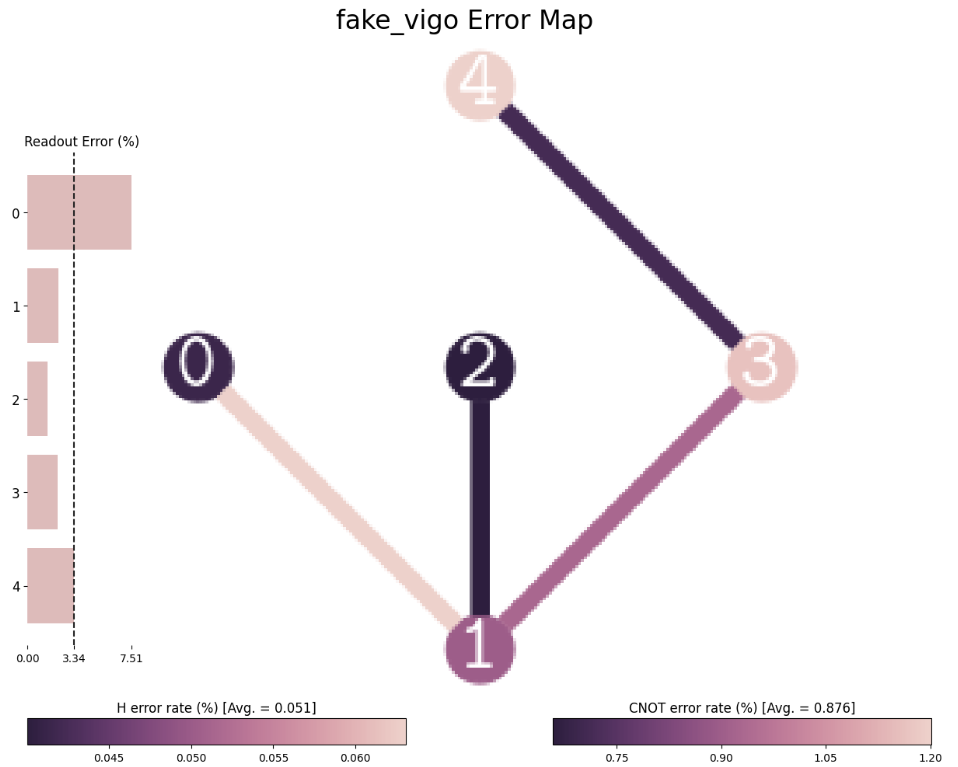

In [10]:
from qiskit.visualization import plot_error_map, plot_circuit_layout

# plot_error_map(FakeVigoV2())

from IPython.display import Image, display
img_path = "img/fakevigoErrorMap.png"
display(Image(filename=img_path))

Transpiler의 기능 중, 양자 회로의 큐비트를 물리적 큐비트에 매핑하는 기능을 사용해 더 나은 실행결과를 얻어 봅시다. 세개의 큐비트를 사용하는 다음의 대상 회로를 만들어 봅시다.

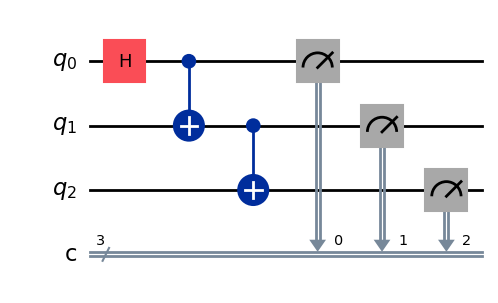

In [11]:
from qiskit import QuantumCircuit

qc=QuantumCircuit(3,3) # 3개의 큐비트와 3개의 고전 비트를 가진 양자 회로를 만듭니다.
qc.h(0) # 0번 큐비트에 하다마드 게이트를 적용합니다.
qc.cx(0,1) # 0번 큐비트를 control 1번 큐비트에 target으로 지정해 CX 게이트를 적용합니다.
qc.cx(1,2) # 1번 큐비트를 control 2번 큐비트에 target으로 지정해 CX 게이트를 적용합니다.
qc.measure([0,1,2],[0,1,2]) # 0,1,2번 큐비트를 0,1,2번 고전 비트에 측정합니다.
qc.draw(output='mpl') # 양자 회로를 그립니다

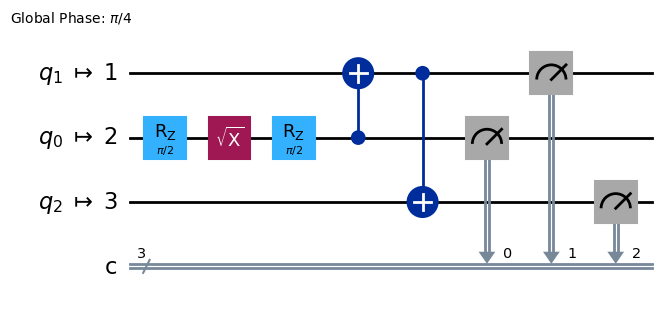

In [12]:
# backend에 맞게 qc 양자 회로를 transpile 해보세요.
# import 부터 시작해보세요
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeValenciaV2
from qiskit.transpiler import generate_preset_pass_manager

backend = FakeVigoV2()

#
pm = generate_preset_pass_manager(backend=backend)
isa_circuit = pm.run(qc)

isa_circuit.draw(output="mpl") # transpile한 qc 양자 회로를 그립니다.

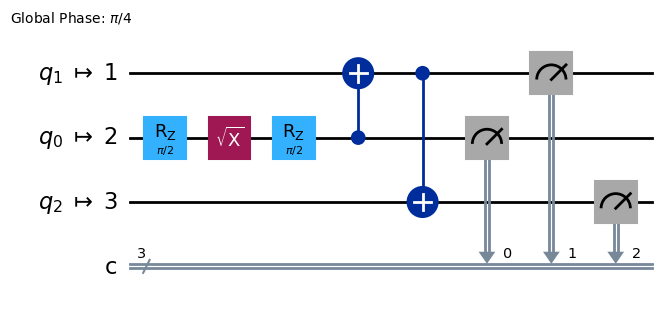

In [13]:
isa_circuit = transpile(qc, backend)
isa_circuit.draw(output="mpl")

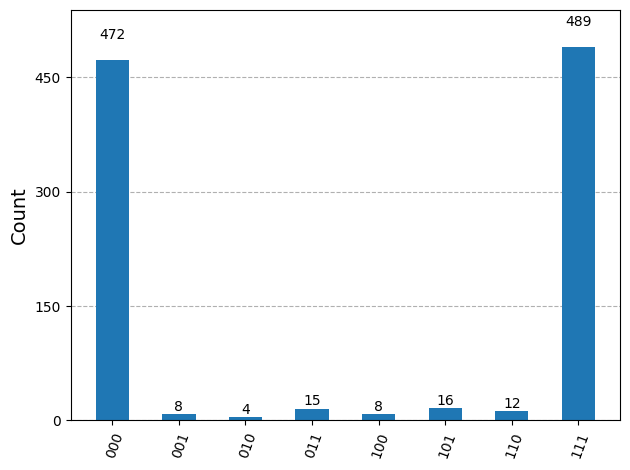

In [14]:
# Sampler를 이용해 양자 회로를 주어진 백엔드에서 실행해보세요.
# import 부터 시작해보세요
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
counts = job.result()[0].data.c.get_counts()

plot_histogram(counts)

transpiler를 사용해서 논리적 큐비트를 물리적 큐비트에 매핑하기 위해서는 `initial_layout`값을 설정해 줄 수 있습니다. 아래의 코드에 강제로 논리적 큐비트 0,1,2를 물리적 큐비트 0, 1,3에 매핑 한 후 plot_histogram을 그려봅시다.

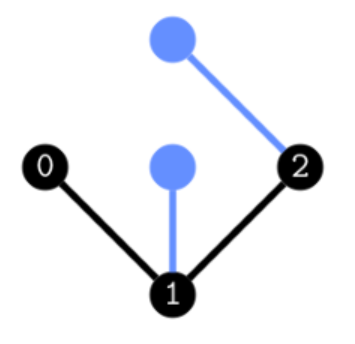

In [18]:
pm = generate_preset_pass_manager(backend=backend, initial_layout=[0,1,3]) #
isa_circuit = pm.run(qc)
# plot_circuit_layout(isa_circuit, backend)

img_path = "img/initialLayout013.png"
display(Image(img_path))

transpile된 회로를 실행해서 counts를 plot_histogram으로 그려 봅시다.

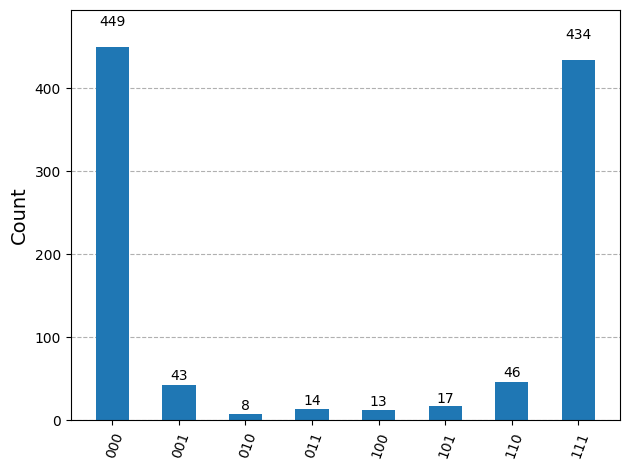

In [20]:
#
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
counts = job.result()[0].data.c.get_counts()

plot_histogram(counts)

 transpiler는 transpile 수준을 0부터 3까지 제공합니다. 새로운 테스트용 회로를 사용해 각각의 레벨로 주어진 회로를 transpile한 후 결과를 그려 봅시다.

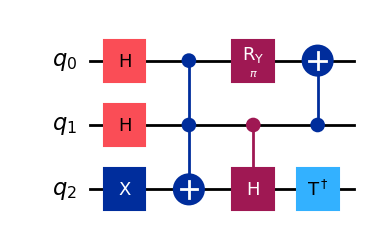

In [21]:
from math import pi

qc_trans=QuantumCircuit(3)
qc_trans.h(range(2))
qc_trans.x(2)
qc_trans.ccx(0,1,2)
qc_trans.ry(pi,0)
qc_trans.ch(1,2)
qc_trans.tdg(2)
qc_trans.cx(1,0)
qc_trans.draw(output='mpl')

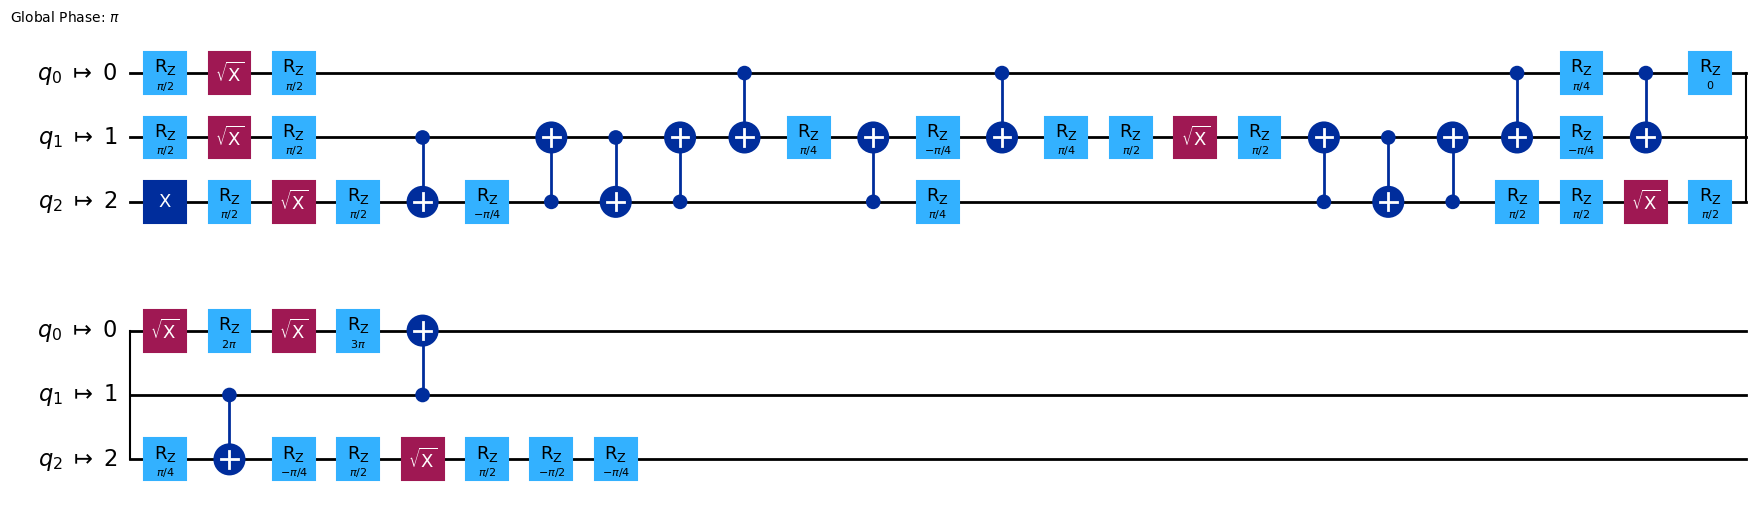

In [23]:
#optimization_level = 0으로 회로를 transpile 한 후 회로를 그려보세요
pm_0 = generate_preset_pass_manager(backend=backend, optimization_level=0)
isa_circuit_0 = pm_0.run(qc_trans)
isa_circuit_0.draw(output="mpl") # 트랜스파일한 qc_trans 양자 회로를 그립니다.

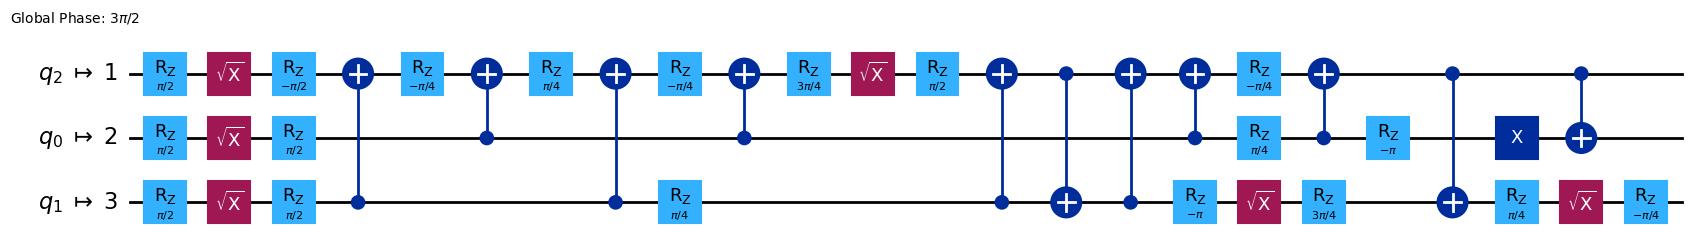

In [24]:
#optimization_level = 1으로 회로를 transpile 한 후 회로를 그려보세요
pm_1 = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit_1 = pm_1.run(qc_trans)
isa_circuit_1.draw(output="mpl") # 트랜스파일한 qc_trans 양자 회로를 그립니다.

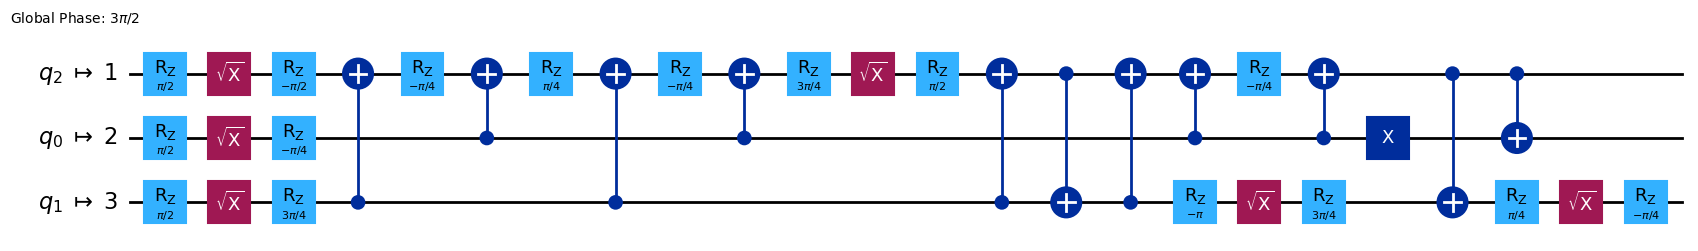

In [25]:
#optimization_level = 2으로 회로를 transpile 한 후 회로를 그려보세요
pm_2 = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit_2 = pm_2.run(qc_trans)
isa_circuit_2.draw(output="mpl") # 트랜스파일한 qc_trans 양자 회로를 그립니다.

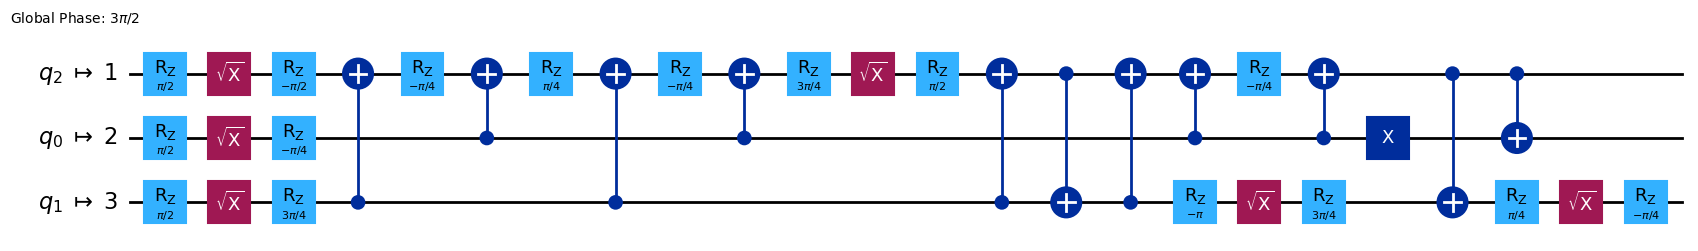

In [26]:
#optimization_level = 3으로 회로를 transpile 한 후 회로를 그려보세요
pm_3 = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit_3 = pm_3.run(qc_trans)
isa_circuit_3.draw(output="mpl") # 트랜스파일한 qc_trans 양자 회로를 그립니다.

In [30]:
# 각각의 최적화 수준으로 transpile된 회로들의 depth와 size를 비교해 보세요.
l = [isa_circuit_0, isa_circuit_1, isa_circuit_2, isa_circuit_3]

for i in range(4):
    print(i," depth: ", l[i].depth(), " size: ", l[i].size())

0  depth:  33  size:  50
1  depth:  23  size:  37
2  depth:  23  size:  34
3  depth:  23  size:  34


### 5-3 : 실제 백엔드를 사용하는 방법

실제 백엔드를 사용하기 위해서는 Qiskit Runtime Service에 접속해서 백엔드를 불러오는 것으로, 나머지 실행 과정은 위와 동일합니다. 서비스에 접속해봅시다.

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name='qgss-2025') # Qiskit 런타임 서비스에 접속합니다.

사용자의 계정이 사용할 수 있는 백엔드의 목록을 가져와 봅시다.

In [32]:
service.backends() # service에서 사용 가능한 백엔드의 목록을 불러옵니다.

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

계정에서, `ibm_brisbane` 백엔드를 `backend()`를 사용해 불러와서 backend로 설정해 봅시다.

In [33]:
backend = service.backend('ibm_brisbane')
backend

<IBMBackend('ibm_brisbane')>

ibmq_provider에서 qubit의 수가 100이상인 백엔드의 목록만 가져와 봅시다.


In [34]:
service.backends(filters=lambda b: b.configuration().n_qubits > 100)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

실제 양자 장치중에서 가장 대기열이 낮은 백엔드 찾기


In [35]:
#
service.least_busy()

<IBMBackend('ibm_brisbane')>

## 5-4: 백엔드로 보내진 Job의 정보의 확인


실습을 위해 임의의 양자 회로를 생성해 봅니다.

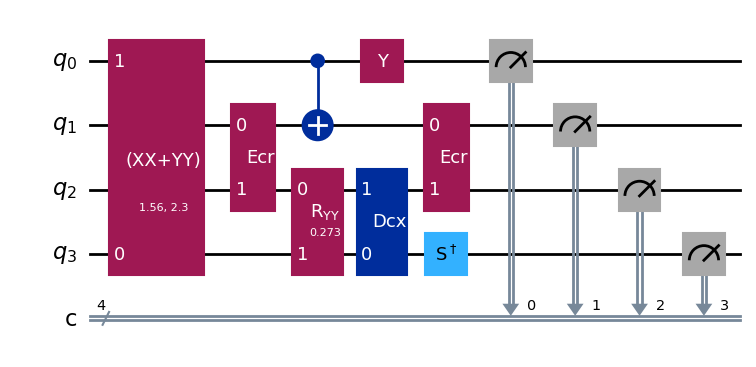

In [36]:
from qiskit.circuit.random import random_circuit
qc = random_circuit(4, 4, measure=True)
qc.draw('mpl')

In [45]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler

backend = AerSimulator() # 백엔드를 지정합니다.
sampler = Sampler(backend)

# job = sampler.run([qc])
pm = generate_preset_pass_manager(backend=backend)
job = sampler.run([pm.run(qc)])

In [46]:
# job id를 출력해 봅시다.

job.job_id()

'ccc95278-0e3a-4367-bb6d-e4af71c10889'

In [47]:
# job의  backend 정보를 확인해 봅시다.

job.backend()

AerSimulator('aer_simulator')

In [48]:
# job의 상태를 확인해 봅시다.

job.status()

<JobStatus.DONE: 'job has successfully run'>

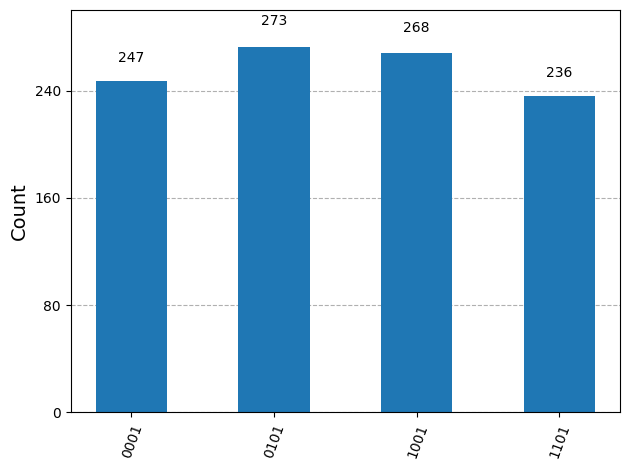

In [56]:
# job이 완료 되었다면 결과를 다시 불러와 결과를 출력해 봅니다.

plot_histogram(job.result()[0].data.c.get_counts())

## Quiz!
1. 다음 그림을 똑같이 만들어 보세요.

![question11](./img/ex8.png)

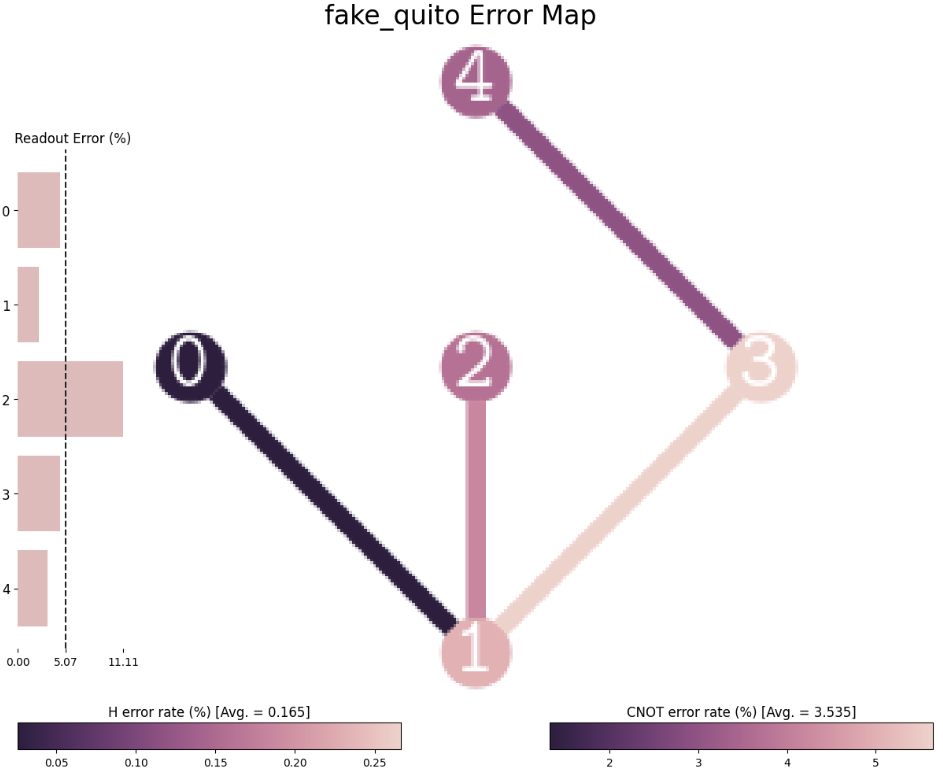

In [57]:
# 
# from qiskit_ibm_runtime.fake_provider import FakeQuitoV2
# from qiskit.visualization import plot_error_map

# backend = FakeQuitoV2()
# plot_error_map(backend)

img_path = "img/fakeQuitoErrorMap.png"
display(Image(img_path))

2. 다음의 코드가 주어졌을때 

In [ ]:
from qiskit import BasicAer, Aer, execute
qc = QuantumCircuit(1)
qc.h(0)

# insert code here


print(unitary)

<IPython.core.display.Latex object>

다음의 결과를 출력하게 해주도록 넣을 수 있는 코드 두가지는 무엇일까요?

```
    [[ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]
    [ 0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j]]

In [ ]:
# A
simulator = BasicAer.get_backend('unitary_simulator')
unitary = execute(qc, simulator).get_unitary(qc)

#B
simulator = Aer.get_backend('unitary_simulator')
result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)

#C
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
unitary = result.get_matrix_result(qc)

#D
simulator = BasicAer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)

#E
simulator = BasicAer.get_backend('unitary_simulator')
result = execute(qc, simulator).result()
unitary = result.get_unitary()


In [63]:
from qiskit import BasicAer, Aer, execute
qc = QuantumCircuit(1)
qc.h(0)

# insert code here
inp = input()

if inp == 'A':
    # A
    simulator = BasicAer.get_backend('unitary_simulator')
    unitary = execute(qc, simulator).get_unitary(qc)
    
elif inp == 'B':
    #B
    simulator = Aer.get_backend('unitary_simulator')
    result = execute(qc, simulator).result()
    unitary = result.get_unitary(qc)
    
elif inp == 'C':
    #C
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    unitary = result.get_matrix_result(qc)
    
elif inp == 'D':
    #D
    simulator = BasicAer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    unitary = result.get_unitary(qc)
    
elif inp == 'E':
    #E
    simulator = BasicAer.get_backend('unitary_simulator')
    result = execute(qc, simulator).result()
    unitary = result.get_unitary()

print(unitary)

ImportError: cannot import name 'BasicAer' from 'qiskit' (c:\WORKS\PNU\2025QiskitGlobalSummerSchool\miniconda3\envs\cwq\Lib\site-packages\qiskit\__init__.py)

In [72]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit_aer import AerSimulator

qc = QuantumCircuit(1)
qc.h(0)

# insert code here
inp = input()

if inp == 'A':
    # A
    # simulator = BasicAer.get_backend('unitary_simulator')
    # unitary = execute(qc, simulator).get_unitary(qc)
    unitary = Operator(qc)
    
elif inp == 'B':
    #B
    # simulator = Aer.get_backend('unitary_simulator')
    # result = execute(qc, simulator).result()
    # unitary = result.get_unitary(qc)
    simulator = AerSimulator()
    qc.save_unitary()
    result = simulator.run(qc).result()
    unitary = result.get_unitary()
    
elif inp == 'C':
    #C
    # simulator = Aer.get_backend('statevector_simulator')
    # result = execute(qc, simulator).result()
    # unitary = result.get_matrix_result(qc)
    simulator = AerSimulator()
    qc.save_statevector()
    result = simulator.run(qc).result()
    unitary = result.get_statevector()
    
elif inp == 'D':
    #D
    # simulator = BasicAer.get_backend('statevector_simulator')
    # result = execute(qc, simulator).result()
    # unitary = result.get_unitary(qc)
    unitary = Statevector(qc)
    
elif inp == 'E':
    #E
    # simulator = BasicAer.get_backend('unitary_simulator')
    # result = execute(qc, simulator).result()
    # unitary = result.get_unitary()
    unitary = Operator(qc)

print(inp)
print()
print(unitary)

B

Operator([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
          [ 0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j]],
         input_dims=(2,), output_dims=(2,))
